In [9]:
import math
import pandas as pd

from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3869685)

df[['x', 'y']] = df['location'].apply(pd.Series)

df = df[df['team'] == 'Argentina']

In [10]:
import pandas as pd

# Assuming average_locs_and_count is calculated or defined elsewhere in your code
# For demonstration purposes, we'll create a sample DataFrame
data = {'player_id': [1, 2, 3, 4],
        'x': [10, 20, 30, 40],
        'y': [50, 60, 70, 80]}
average_locs_and_count = pd.DataFrame(data)

# Assuming jersey_numbers is also defined elsewhere in your code
# For demonstration purposes, we'll create a sample DataFrame
jersey_numbers = pd.DataFrame({'player_id': [1, 2, 3, 4],
                                'jersey_number': [10, 20, 30, 40]})

# Then you can iterate over average_locs_and_count in the for loop
for index, row in average_locs_and_count.iterrows():
    player_numbers = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values
    if len(player_numbers) > 0:
        player_number = player_numbers[0]
        # Replace pitch.annotate with the appropriate method to annotate player numbers on the pitch plot
        print(f"Player {row.name} has jersey number {player_number}")
    else:
        print(f"Player {row.name} has no assigned jersey number")

# The above print statements are for demonstration purposes.
# Replace them with the actual code to plot the player numbers using the 'pitch' object.


Player 0 has no assigned jersey number
Player 1 has jersey number 10
Player 2 has jersey number 20
Player 3 has jersey number 30


In [11]:
# Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60 * df["minute"] + df["second"]

df.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
df['passer'] = df['player_id']

df['recipient'] = df['passer'].shift(-1)

# filter for only passes and then successful passes
passes_df = df.loc[(df['type']=="Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

#find time of the team's first substitution and filter the df to only passes before that
sub_df = df.loc[(df['type'] == "Substitution")]
first_sub = sub_df["newsecond"].min()

if first_sub <= (60 * 45):
    first_sub = 60 * 45

completions = completions.loc[completions['newsecond'] < first_sub]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# find number of passes along each 'path' of passer to recipient
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

C:\Users\Ayush\AppData\Local\Temp\ipykernel_1804\4154787335.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


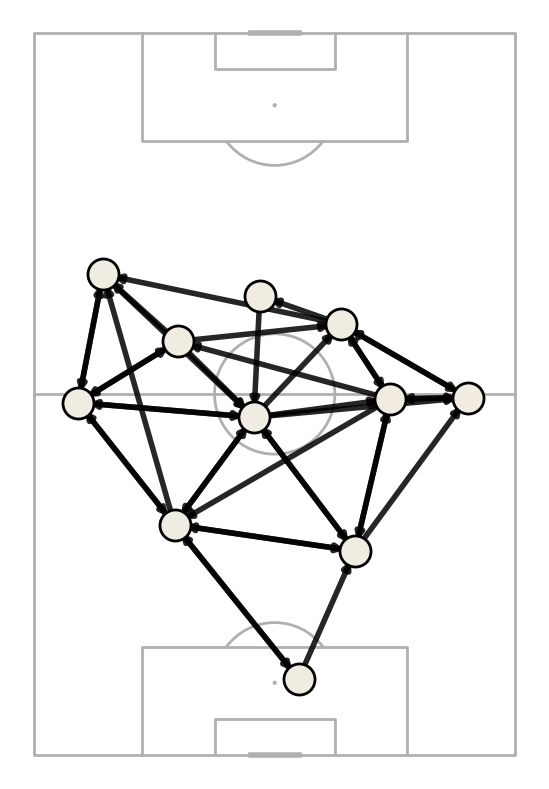

In [12]:

# plot arrows
def pass_line_template(ax, x, y, end_x, end_y, line_color):
    ax.annotate(
        '',
        xy=(end_y,  end_x),
        xytext=(y, x),
        zorder=1,
        arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
    )
    
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y-y, end_x-x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)

pitch = VerticalPitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(12, 8))

for index, row in passes_between.iterrows():
    pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')

# plot nodes
pitch.scatter(
    average_locs_and_count.x, average_locs_and_count.y, s=500,
    color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
)
